# PAYGO LOAN DEFAULT

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error as mse
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

C:\Users\Aseta\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc = pyspark.SparkContext('local[*]')
sql_context = SQLContext(sc)

In [176]:
train = sql_context.read.csv('Train.csv',header=True , inferSchema=True)
#train.printSchema()
metadata = sql_context.read.csv('metadata.csv',header=True, inferSchema=True)
#metadata.printSchema()
#metadata.show(3)

In [180]:
for col in ['RegistrationDate','ExpectedTermDate','FirstPaymentDate','LastPaymentDate']:
    metadata = metadata.withColumn(col, to_timestamp(metadata[col],'dd/MM/yyyy HH:mm') )

metadata = metadata.withColumn('days_left_to_deadline', datediff('ExpectedTermDate','LastPaymentDate')) 
metadata = metadata.withColumn('days_from_start', datediff('LastPaymentDate','RegistrationDate'))

metadata_col_drop =('PaymentMethod','SupplierName','UpsellDate','AccessoryRate','Town',
               'RegistrationDate','ExpectedTermDate','FirstPaymentDate','LastPaymentDate')
metadata = metadata.drop(*metadata_col_drop)
metadata.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Deposit: integer (nullable = true)
 |-- rateTypeEntity: string (nullable = true)
 |-- RatePerUnit: integer (nullable = true)
 |-- DaysOnDeposit: integer (nullable = true)
 |-- MainApplicantGender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Term: integer (nullable = true)
 |-- TotalContractValue: integer (nullable = true)
 |-- days_left_to_deadline: integer (nullable = true)
 |-- days_from_start: integer (nullable = true)



In [181]:
def hist_to_list(x):
    return (list(map(float, x.strip('[]').split(','))))


list_from_hist = udf(hist_to_list,ArrayType(FloatType()))
mean_udf = udf(lambda x: float(np.mean(x)), FloatType())
age_grouper_udf = udf(age_grouper,StringType())


def age_grouper(x):
    if type(x)== int:
        if x<30:
            return '<31'
        elif x<50:
            return '31-60'
        else:
            return '>60'
    else:
        return 'other' #not given or missing

        
def create_dict_converter(df):#train_data
    # Get dictionaries for labels
    for i in df.columns:
        print(i)
        if df.select(i).dtypes[0][i] == 'string' and i!= 'ID' :
            new_dict = dict()
            for j,unique_value in enumerate( df.select(i).distinct().collect() ):
                new_dict[unique_value.i] = j
                #print(unique_value.i)
            name_ = 'dict_'+str(unique_value.i) 
            globals()[name_]=new_dict
            
            
def unda_df(df):#train
    df = df.withColumn('max_pay',array_max(list_from_hist('PaymentsHistory')))
    df = df.withColumn('min_pay',array_min(list_from_hist('PaymentsHistory')))
    df = df.withColumn('mean_pay', mean_udf(list_from_hist('PaymentsHistory')))
    df = df.drop('PaymentsHistory','TransactionDates')
    data_df = metadata.join(df,'ID','outer')

    df_data = data_df.withColumn('Age',age_grouper_udf('Age') )
    df_data = df_data.fillna('Not Given' , subset=['Region'])
    return df_data

In [182]:
train_data = unda_df(train)

In [185]:
train_data.show(3)

+----------+-------+--------------+-----------+-------------+-------------------+-----+------------------+----------+----+------------------+---------------------+---------------+------+------+------+------+------+------+-------+-------+---------+
|        ID|Deposit|rateTypeEntity|RatePerUnit|DaysOnDeposit|MainApplicantGender|  Age|            Region|Occupation|Term|TotalContractValue|days_left_to_deadline|days_from_start|    m1|    m2|    m3|    m4|    m5|    m6|max_pay|min_pay| mean_pay|
+----------+-------+--------------+-----------+-------------+-------------------+-----+------------------+----------+----+------------------+---------------------+---------------+------+------+------+------+------+------+-------+-------+---------+
|ID_05JKQ04|   2500|         DAILY|         55|            3|               Male|other|           Western|  Business| 556|             33080|                 -204|            760|1155.0|1265.0|1320.0|1100.0|1322.0|1184.0| 2610.0|  385.0|   1286.7|
|ID_08KX

In [173]:
'''
def create_dict_converter(df):#train_data
    # Get dictionaries for labels
    for i in df.columns:
        if df[i].dtype == 'object' and i!= 'ID' :
            new_dict = dict()
            for j,unique_value in enumerate(df[i].unique()):
                new_dict[unique_value] = j
            name_ = 'dict_'+str(i) 
            globals()[name_]=new_dict
'''                  
            

    
def unda_df_2(df_data):
    for i in df_data.columns:
        if df_data[i].dtype == 'object' and i!= 'ID' :
            df_data[i] = df_data[i].astype("category")
            df_data[i] = df_data[i].apply(lambda x:globals()['dict_'+str(i)][x])
    
    df_data = df_data.set_index('ID')
    df_data_reduced = df_data.drop(['rateTypeEntity','RatePerUnit','DaysOnDeposit'], axis=1)
    return df_data_reduced

def train_data_only(df_data_reduced):
    df_data_reduced_ = df_data_reduced[[i for i in df_data_reduced.columns if i not in ['m1','m2','m3','m4','m5','m6']]]
    df_data_reduced_[['m1','m2','m3','m4','m5','m6']] = df_data_reduced[['m1','m2','m3','m4','m5','m6']]    
    return df_data_reduced_

In [174]:
train_data = unda_df(train)
create_dict_converter(train_data)
train_data_reduced_ = unda_df_2(train_data)
train_data_reduced = train_data_only(train_data_reduced_)

C:\Users\Aseta\Anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [175]:
train_data_reduced.head()

,Deposit,MainApplicantGender,Age,Region,Occupation,Term,TotalContractValue,days_to/past_deadline,days_from_start,mean_payment,max_payment,min_payment,m1,m2,m3,m4,m5,m6
ID,,,,,,,,,,,,,,,,,,
ID_K00S4N4,2000,0,0,0,0,364,14740,45,318,1422.000000,3050.0,910.0,1225.0,1050.0,1190.0,525.0,1750.0,1890.0
ID_102CV85,2000,1,0,1,1,392,29480,-20,411,1281.111111,4245.0,735.0,980.0,980.0,1225.0,980.0,935.0,355.0
ID_HXBJFHB,2000,1,0,2,2,364,14740,-181,544,1006.363636,2245.0,250.0,250.0,1000.0,250.0,500.0,560.0,1150.0
ID_3K9VZ5J,2000,1,1,0,0,364,14740,-164,527,894.166667,2750.0,280.0,630.0,805.0,700.0,855.0,245.0,775.0
ID_6YU5YRB,2000,0,1,0,0,364,14740,-4,367,1254.285714,3010.0,665.0,1050.0,985.0,1085.0,980.0,1770.0,90.0


In [166]:
train_data_reduced.shape

(28007, 18)

In [138]:
'''
plt.figure(figsize=(13,13))
sns.heatmap(train_data_reduced.corr(),annot=True)
'''

'\nplt.figure(figsize=(13,13))\nsns.heatmap(train_data_reduced.corr(),annot=True)\n'

In [139]:
'''
not_to_plot=['m1','m2','m3','m4','m5','m6','MainApplicantGender', 'Age', 'Region', 'Occupation']

plt.rcParams['figure.figsize']=(14,30)#len(train_data_reduced.columns)*3))
fig, ax = plt.subplots(len(train_data_reduced.columns)-len(not_to_plot),1,gridspec_kw={'hspace':1,'width_ratios': [0.4]})

for i,j in enumerate([i for i in train_data_reduced.columns if i not in not_to_plot]):
    ax[i].boxplot(train_data_reduced[j],vert=0,)
    ax[i].set_title(j)
'''

"\nnot_to_plot=['m1','m2','m3','m4','m5','m6','MainApplicantGender', 'Age', 'Region', 'Occupation']\n\nplt.rcParams['figure.figsize']=(14,30)#len(train_data_reduced.columns)*3))\nfig, ax = plt.subplots(len(train_data_reduced.columns)-len(not_to_plot),1,gridspec_kw={'hspace':1,'width_ratios': [0.4]})\n\nfor i,j in enumerate([i for i in train_data_reduced.columns if i not in not_to_plot]):\n    ax[i].boxplot(train_data_reduced[j],vert=0,)\n    ax[i].set_title(j)\n"

### Base Model

In [140]:
'''
x = train_data[[i for i in train_data.columns if i not in ['m1','m2','m3','m4','m5','m6']]]
y = train_data[['m1','m2','m3','m4','m5','m6']]
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size= 0.2, random_state=12)

model = RFR(n_estimators = 500, max_depth=4)
model.fit(train_x,train_y)
model_result = model.predict(test_x)
print('MSE : ',mse(model_result,test_y),'\nRMSE : ',mse(model_result,test_y,squared=False))
plt.figure(figsize=(10,10))
plt.barh(train_x.columns,model.feature_importances_ )
'''

"\nx = train_data[[i for i in train_data.columns if i not in ['m1','m2','m3','m4','m5','m6']]]\ny = train_data[['m1','m2','m3','m4','m5','m6']]\ntrain_x,test_x,train_y,test_y = train_test_split(x,y,test_size= 0.2, random_state=12)\n\nmodel = RFR(n_estimators = 500, max_depth=4)\nmodel.fit(train_x,train_y)\nmodel_result = model.predict(test_x)\nprint('MSE : ',mse(model_result,test_y),'\nRMSE : ',mse(model_result,test_y,squared=False))\nplt.figure(figsize=(10,10))\nplt.barh(train_x.columns,model.feature_importances_ )\n"

### MODEL

In [176]:
x = train_data_reduced[[i for i in train_data_reduced.columns if i not in ['m1','m2','m3','m4','m5','m6']]]
y = train_data_reduced[['m1','m2','m3','m4','m5','m6']]
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size= 0.2, random_state=12)


In [178]:
'''
model = RFR()
param_dict = {
    'n_estimators' : np.arange(300,800,100),
    'max_depth' : np.arange(7,13) 
}
gcv_search = GridSearchCV(model, param_grid=param_dict, n_jobs=-1, cv=10)
search = gcv_search.fit(train_x,train_y)
search.best_params_
'''

"\nmodel = RFR()\nparam_dict = {\n    'n_estimators' : np.arange(300,800,100),\n    'max_depth' : np.arange(7,13) \n}\ngcv_search = GridSearchCV(model, param_grid=param_dict, n_jobs=-1, cv=10)\nsearch = gcv_search.fit(train_x,train_y)\nsearch.best_params_\n"

MSE :  420368.0740026815 
RMSE :  584.9357509526313


<BarContainer object of 12 artists>

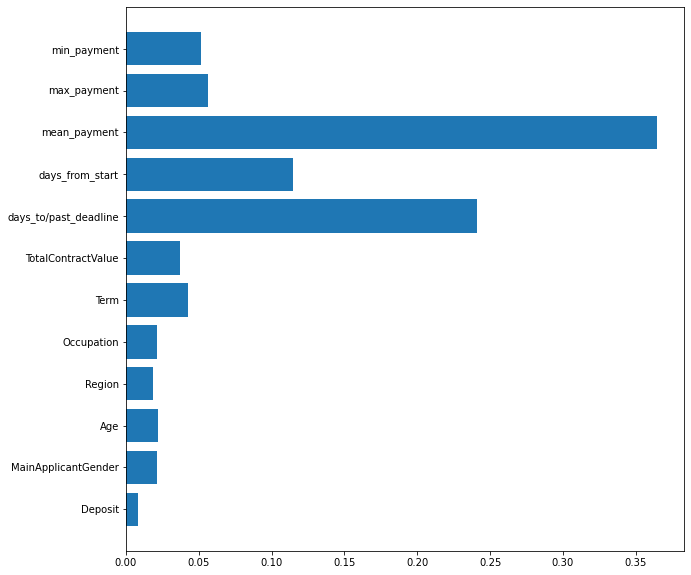

In [179]:
model = RFR(n_estimators= 600, max_depth=10)
model.fit(train_x, train_y)
model_result = model.predict(test_x)
print('MSE : ',mse(model_result,test_y),'\nRMSE : ',mse(model_result,test_y,squared=False))
plt.figure(figsize=(10,10))
plt.barh(train_x.columns,model.feature_importances_ )

In [144]:
#pipeline = Pipeline(steps =[('unda_df',unda_df(train)) ,('unda_df_2',unda_df_2(train_data)), ('model',RFR(n_estimators= 500, max_depth=10))] )

In [180]:
test = pd.read_csv("Test.csv")
test_data = unda_df(test)
test_data_reduced_ = unda_df_2(test_data)

In [184]:
model_result = model.predict(test_data_reduced_)

model_result_df=pd.DataFrame(model_result,index=test_data_reduced_.index, columns=['m1','m2','m3','m4','m5','m6'])
model_result_df = model_result_df.stack().reset_index()
model_result_df['ID']= model_result_df[['ID','level_1']].agg(' x '.join, axis=1)
model_result_df = model_result_df.drop('level_1',axis=1).rename(columns={0:'Target'}).set_index('ID')
model_result_df.to_csv("Submission.csv")
model_result_df.head()

,Target
ID,
ID_6L67PAA x m1,705.846229
ID_6L67PAA x m2,983.588503
ID_6L67PAA x m3,533.701003
ID_6L67PAA x m4,757.632014
ID_6L67PAA x m5,817.279000
